# Inspecting training data <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


## Background

Prior to training a machine learning classifier, it can be useful to understand which feature layers are actually useful for distinguishing between classes. The feature layers the model is trained on form the **knowledge base** of the algorithm. We can explore this knowledge base using class-specific [violin plots](https://en.wikipedia.org/wiki/Violin_plot#:~:text=A%20violin%20plot%20is%20a,by%20a%20kernel%20density%20estimator.), and through a dimensionality reduction approach called [principal-components analysis](https://builtin.com/data-science/step-step-explanation-principal-component-analysis), which transforms our large dataset with lots of variables into a smaller dataset with fewer variables but which can still explain much of the variance in our dataset. 


## Description

Using the training data written to file in the previous notebook [1_Extract_training_data](1_Extract_training_data.ipynb), this notebook will:

1. Plot class-specific violin plots for each of the feature layers in the training data,
2. Calculating the first two prinicpal components of the dataset and plot them as a scatter plot.

> This notebook is provided as an exploratory means to better understand the dataset we're working with. It does not produce any outputs that are required for subsequent notebooks.

***

## Load packages

In [1]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## Analysis Parameters

* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `class_dict`: A dictionary mapping the 'string' name of the classes to the integer values that represent our classes in the training data (e.g. `{'crop': 1., 'noncrop': 0.}`)
* `field`: This is the name of column in the original training data shapefile that contains the class labels. This is provided simply so we can remove this attribute before we plot the data

In [2]:
training_data = "results/training_data/test_training_data.txt"

class_dict = {'crop':1, 'noncrop':0}

field = 'class'

## Import training data


In [3]:
# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

## Data Wrangling

This cell extract each class in the training data array and assigns it to a dictionary, this step will allow for cleanly plotting our data

In [4]:
dfs = {}
for key, value in class_dict.items():
    print(key)
    
    # extract values for class from training data
    arr = model_input[model_input[:,0]==value]
    
    # create a pandas df for ease of use later
    df = pd.DataFrame(arr).rename(columns={i:column_names[i] for i in range(0,len(column_names))}).drop(field, axis=1)
    
    # Normalise 0-1 for plotting purposes
    df = (df-df.min())/(df.max()-df.min())
    
    dfs.update({key:df})

crop
noncrop


## Feature layer violin plots

TODO:
- figure out how to automate the offsets...changes with number of classes
        
        if len(dfs) == 2:
            offsets = [-.2, 0.2]
            width = 0.4

        if len(dfs) == 3:
            offsets = [-.2, 0.66, 0.2]
            width = 0.4

        if len(dfs) == 4:
            offsets = [-.2, -0.1, 0., 0.1]
            width = 0.4

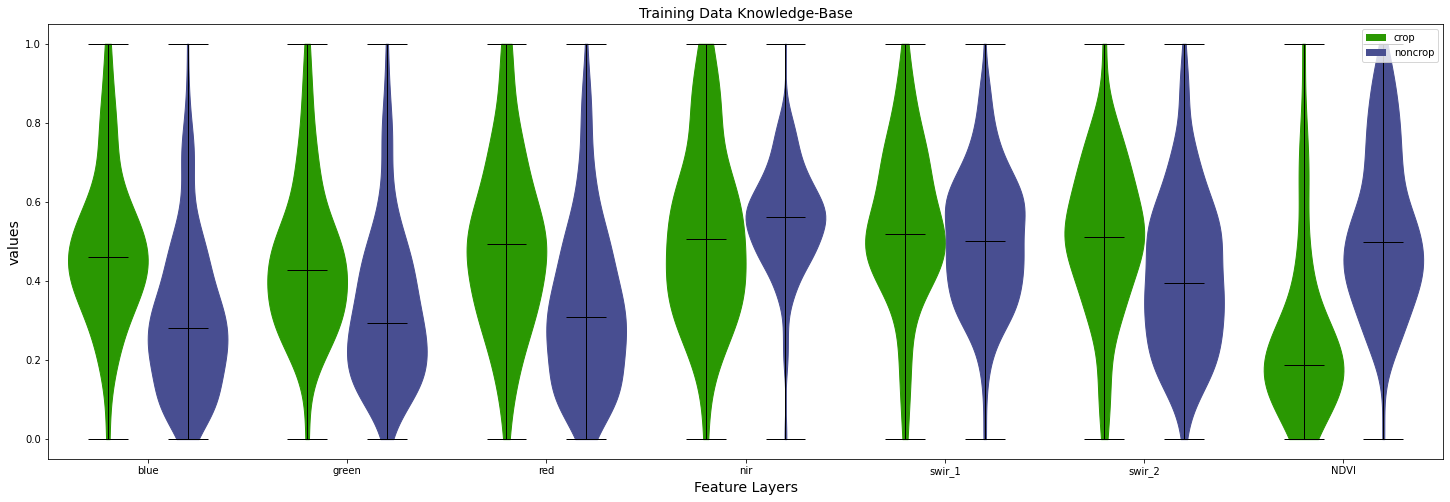

In [5]:
#generate a random list of colors same length as num of classes 
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(dfs))

#generate list of offsets for plotting
offsets = [-.2, 0.2]

fig, ax = plt.subplots(figsize=(25,8))

for key, color, offset in zip(dfs,colors, offsets):
    #create violin plots
    pp = ax.violinplot(dfs[key].values,
                       showmedians=True,
                       positions=np.arange(dfs[key].values.shape[1])+offset, widths=0.4,
                      )
    # change the colour of the plots
    for pc in pp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(1)
    
    #change the line style in the plots
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = pp[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

#tidy the plot, add a title and legend
ax.set_xticks(np.arange(len(column_names[1:])))
ax.set_xticklabels(column_names[1:])
ax.set_xlim(-0.5,len(column_names[1:])-.5)
ax.set_ylabel("values", fontsize=14)
ax.set_xlabel("Feature Layers", fontsize=14)
ax.set_title("Training Data Knowledge-Base", fontsize=14)
ax.legend([Patch(facecolor=c) for c in colors], [key for key in dfs], loc='upper right')

plt.show()

## Principal Component Analysis

The code below will calculate and plot the first two principal components of our training dataset. 

The first step is to normalise our data to express each feature layer in terms of mean and standard deviation, this is necessary becvause principal component analysis is quite sensitive to the variances of the initial variables. If there are large differences between the ranges of initial variables, those variables with larger ranges will dominate over those with small ranges (For example, a variable that ranges between 0 and 100 will dominate over a variable that ranges between 0 and 1), which will lead to biased results. So, transforming the data to comparable scales can prevent this problem.  We do this using sklearn's `StandardScalar` function which will normalise the values in an array to the array's mean and standard deviation via the formuala: `z = (x-u/s)`, where `u` is the mean of and `s` is the standard deviation.

In [6]:
# Compute the mean and variance for each feature
scalar = StandardScaler().fit(model_input[:,1:])

# apply transformations to the training data
x = scalar.transform(model_input[:,1:])

Now conduct the PCA using two components

In [7]:

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(x)

#add back to df
pca_df = pd.DataFrame(data = pca_fit,
                      columns = ['PC1', 'PC2'])

# concat with classes
df = pd.concat([pca_df, pd.DataFrame({'class':model_input[:,0]})], axis=1)

In [8]:
a,b = pca.explained_variance_ratio_
print("Variance explained by two principal components = " + str(round((a+b)*100, 2))+" %")

Variance explained by two principal components = 95.64 %


### Plot the first two principal components


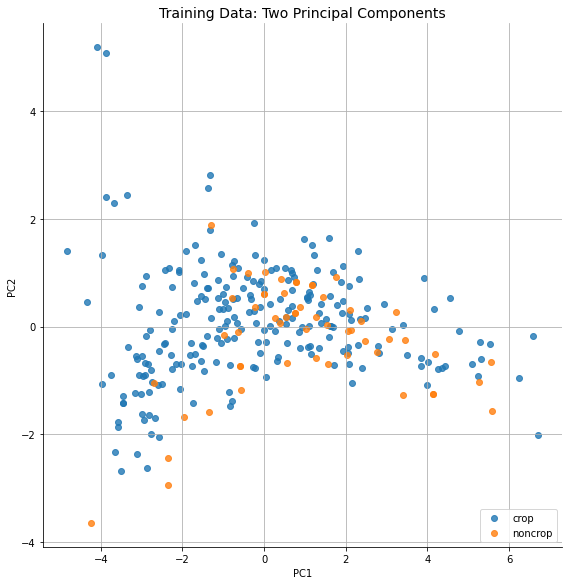

In [9]:
sns.lmplot(x="PC1", y="PC2",
           data=df,
           fit_reg=False,
           hue='class',
           legend=False,
           height=8,
          )

plt.legend(tuple(key for key in dfs), loc='lower right')
plt.title('Training Data: Two Principal Components', fontsize=14)
plt.grid();